In [22]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import os
import cv2
import SRGAN
from natsort import natsorted
from matplotlib import pyplot as plt

# 定义设备
device = torch.device("cuda", 0)
# 生成器的类型
g_arch_name = "srresnet_x4"
# 模型参数
in_channels = 3
out_channels = 3
channels = 64
num_rcb = 16

# 测试数据
lr_dir = f"./data/Set5/LRbicx4"
sr_dir = f"./results/test/SRGAN_x4-Set5"
gt_dir = f"./data/Set5/GTmod12"

# 训练权重
model_weight = f"./checkpoint/SRGAN_x4.pth.tar"


In [23]:
# 计算psnr
def calc_psnr(img1, img2):
    img1 = Image.fromarray(img1)
    img2 = Image.fromarray(img2)
    img1 = transforms.ToTensor()(img1).unsqueeze(0)
    img2 = transforms.ToTensor()(img2).unsqueeze(0)
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))

# 预处理
def preprocess(image_path: str, device: torch.device):
    image = cv2.imread(image_path).astype(np.float32) / 255.0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 色彩空间转换
    tensor = torch.from_numpy(np.ascontiguousarray(image)).permute(2, 0, 1).float().unsqueeze_(0)
    tensor = tensor.to(device=device, memory_format=torch.channels_last, non_blocking=True)
    return tensor

Load model weights form srresnet_x4 
Processing ./data/Set5/LRbicx4\baby.png
image: ./data/Set5/GTmod12\baby.png PSNR: tensor(30.6421)


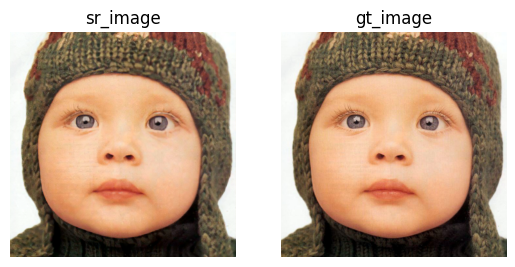

Processing ./data/Set5/LRbicx4\bird.png
image: ./data/Set5/GTmod12\bird.png PSNR: tensor(29.8084)


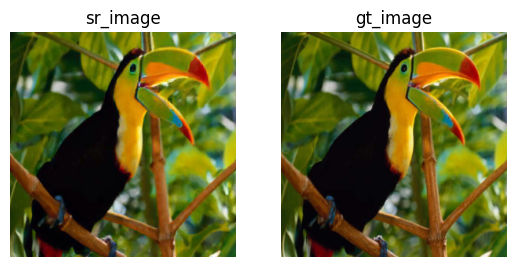

Processing ./data/Set5/LRbicx4\butterfly.png
image: ./data/Set5/GTmod12\butterfly.png PSNR: tensor(25.2557)


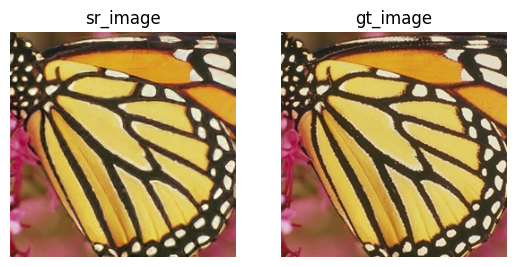

Processing ./data/Set5/LRbicx4\head.png
image: ./data/Set5/GTmod12\head.png PSNR: tensor(28.8209)


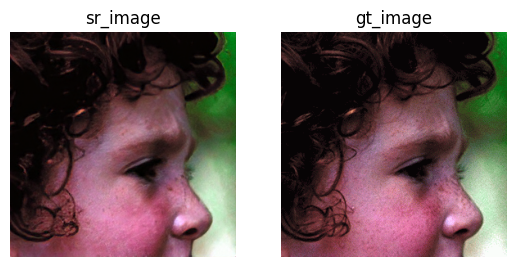

Processing ./data/Set5/LRbicx4\woman.png
image: ./data/Set5/GTmod12\woman.png PSNR: tensor(27.7548)


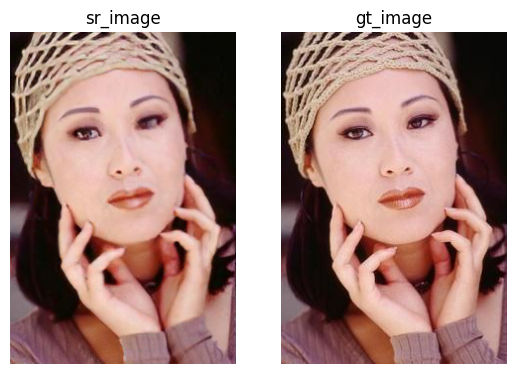

In [24]:
def main():
    # 模型初始化
    g_model = SRGAN.__dict__[g_arch_name](in_channels=in_channels,
                                                       out_channels=out_channels,
                                                       channels=channels,
                                                       num_rcb=num_rcb).to(device=device)

    # 加载预训练模型
    checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage)
    g_model.load_state_dict(checkpoint["state_dict"])
    print(f"Load model weights form {g_arch_name} ")

    g_model.eval()

    # 按照文件名的正常语序进行排序
    file_names = natsorted(os.listdir(lr_dir))
    # Get the number of test image files.
    total_files = len(file_names)

    for index in range(total_files):
        # 低分辨率图像路径
        lr_image_path = os.path.join(lr_dir, file_names[index])
        # 模型结果的保存路径
        sr_image_path = os.path.join(sr_dir, file_names[index])
        # 原图路径
        gt_image_path = os.path.join(gt_dir, file_names[index])

        print(f"Processing {lr_image_path}")
        lr_tensor = preprocess(lr_image_path, device)

        # 预测结果
        with torch.no_grad():
            sr_tensor = g_model(lr_tensor)

        sr_image = sr_tensor.squeeze(0).permute(1, 2, 0).mul(255).clamp(0, 255).cpu().numpy().astype("uint8")
        sr_image = cv2.cvtColor(sr_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(sr_image_path, sr_image)

        # 计算PSNR
        gt_image = cv2.imread(gt_image_path)
        pred = sr_image
        print('image:', gt_image_path, 'PSNR:', calc_psnr(gt_image, pred))

        sr_image = cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB)
        gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)
        # 创建子图，显示第一张图片
        plt.subplot(1, 2, 1)
        plt.imshow(sr_image)
        plt.title('sr_image')
        plt.axis('off')

        # 创建子图，显示第二张图片
        plt.subplot(1, 2, 2)
        plt.imshow(gt_image)
        plt.title('gt_image')
        plt.axis('off')

        # 显示图片
        plt.show()

if __name__ == "__main__":
    main()
